In [1]:
import pickle
import json
# import seaborn as sns
import matplotlib.transforms as mtransforms
from bread import vis
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bread.algo import tracking
from bread.data import *
from sklearn.metrics import confusion_matrix
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
from glob import glob
import sys
import os.path
sys.path.append('../../src/libraries')  # import YeaZ

In [2]:
seg_0 = SegmentationFile.from_h5(
    '../../data/segmentations/colony000_segmentation.h5').get_segmentation("FOV0")
microscopy = Microscopy.from_tiff(
    '../../data/microscopies/colony000_microscopy.tif')
feat_0 = Features(seg_0, nn_threshold=12, scale_length=1, scale_time=1)

seg_external = SegmentationFile.from_h5(
    '../../data/segmentations/colony006_segmentation.h5').get_segmentation("FOV0")
# microscopy = Microscopy.from_tiff(
    # '../../data/microscopies/colony000_microscopy.tif')
feat_external = Features(seg_external, nn_threshold=12, scale_length=1, scale_time=1)

seg_3 = SegmentationFile.from_h5(
    '../../data/segmentations/colony003_segmentation.h5').get_segmentation("FOV0")
# microscopy = Microscopy.from_tiff(
    # '../../data/microscopies/colony000_microscopy.tif')
feat_3 = Features(seg_3, nn_threshold=12, scale_length=1, scale_time=1)
seg_5 = SegmentationFile.from_h5(
    '../../data/segmentations/colony005_segmentation.h5').get_segmentation("FOV0")
# microscopy = Microscopy.from_tiff(
    # '../../data/microscopies/colony000_microscopy.tif')
feat_5 = Features(seg_5, nn_threshold=12, scale_length=1, scale_time=1)

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import required libraries
from numpy.linalg import norm


def get_fourier_descriptors(area, n_points, locality=False):
    # Compute the contour of the area
    contours, _ = cv2.findContours(
        area, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    contour = contours[0]

    normalized_contour = normalize_contour(contour, n_points)
    # Convert normalized_contour points to polar coordinates
    normalized_contour_shape = normalized_contour.shape
    normalized_contour_complex = np.empty(
        (normalized_contour_shape[0],), dtype=complex)
    normalized_contour_complex.real = normalized_contour[:, 0, 0]
    normalized_contour_complex.imag = normalized_contour[:, 0, 1]

    # Compute the Fourier descriptors
    fourier_descriptors = np.fft.fft(normalized_contour_complex)
    if locality == False:
        fourier_descriptors[0] = 0

    return fourier_descriptors


def compare_fourier_descriptors(desc1, desc2):
    # Normalize the descriptors
    desc1_norm = desc1 / np.abs(desc1[1])
    desc2_norm = desc2 / np.abs(desc2[1])

    # Compute the Euclidean distance between the descriptors
    distance = np.linalg.norm(desc1_norm - desc2_norm)
    a = desc1_norm
    b = desc2_norm
    cos_sim = (a @ b.T) / (norm(a)*norm(b))
    cosine_similarity = np.dot(desc1_norm,desc2_norm)/(norm(desc1_norm)*norm(desc2_norm))
    return distance, cos_sim


def normalize_contour(contour, n_points):
    contour_length = contour.shape[0]
    contour_indices = np.linspace(0, contour_length - 1, n_points).astype(int)
    normalized_contour = contour[contour_indices]
    return normalized_contour


In [53]:
import numpy as np
x = np.array([[1,4],[3,6]])
x[:,0]

array([1, 3])

In [4]:

def get_df_fourier(seg, t, t_dist, n_points, locality=False):
    cell_ids = seg.cell_ids(t)
    cell_ids_next = seg.cell_ids(t+t_dist)
    cells_desc = []
    cells_next_desc = []
    label = []
    similaritys = []
    for x in cell_ids:
        area = (seg[t] == x).astype(np.uint8)
        cells_desc.append(get_fourier_descriptors(area, n_points, locality=locality))
    for x in cell_ids_next:
        area = (seg[t+t_dist] == x).astype(np.uint8)
        cells_next_desc.append(get_fourier_descriptors(area, n_points, locality=locality))
    compare_pd = pd.DataFrame(columns=['cell_curr', 'cell_next', 'dist'])
    cells1 = []
    cells2 = []
    dists = []
    first_cell_fourier = []
    second_cell_fourier = []
    for i, x in enumerate(cells_desc):
        for j, y in enumerate(cells_next_desc):
            cells1.append(cell_ids[i])
            cells2.append(cell_ids_next[j])
            if cell_ids[i] == cell_ids_next[j]:
                label.append(1)
            else:  
                label.append(0)
            
            x_magnitude = abs(x)
            x_phase = np.angle(x)
            y_magnitude = abs(y)
            y_phase = np.angle(y)
            # Append the real-valued features to your lists
            x_simple = np.concatenate([x_magnitude, x_phase])
            y_simple = np.concatenate([y_magnitude, y_phase])

            first_cell_fourier.append(x_simple)
            second_cell_fourier.append(y_simple)
            dist , sim = compare_fourier_descriptors(x_simple, y_simple)
            similaritys.append(sim)
            dists.append(dist)

    compare_pd['cell_curr'] = cells1
    compare_pd['cell_next'] = cells2
    compare_pd['dist'] = dists
    compare_pd['similarity'] = similaritys
    columns_to_set = [f'f1_{i}' for i in range(1, 2*n_points + 1)]
    compare_pd[columns_to_set] = pd.DataFrame(first_cell_fourier)
    columns_to_set2 = [f'f2_{i}' for i in range(1, 2*n_points + 1)]
    compare_pd[columns_to_set2] = pd.DataFrame(second_cell_fourier)
    compare_pd['label'] = label
    columns_to_set_diff = [f'f_diff_{i}' for i in range(1, 2*n_points + 1)]
    compare_pd[columns_to_set_diff] =np.abs( np.array(first_cell_fourier) - np.array(second_cell_fourier))
    return compare_pd

In [5]:
def get_features(feature_tool_box, time_id, cell_id):
    area = feature_tool_box.cell_area(time_id, cell_id)
    cell_r_equiv = feature_tool_box.cell_r_equiv(time_id, cell_id)
    cell_r_major = feature_tool_box.cell_r_maj(time_id, cell_id)
    cell_r_minor = feature_tool_box.cell_r_min(time_id, cell_id)
    cell_alpha = feature_tool_box.cell_alpha(time_id, cell_id)
    cell_ecc = feature_tool_box.cell_ecc(time_id, cell_id)
    cell_maj_x, cell_maj_y = feature_tool_box.cell_maj(cell_id, time_id)
    cell_min_x, cell_min_y = feature_tool_box.cell_min(cell_id, time_id)
    cell_x, cell_y = feature_tool_box.cell_cm(time_id, cell_id)

    return {
        # 'cell_id': cell_id,
        'area': area,
        'cell_r_equiv': cell_r_equiv,
        'cell_r_major': cell_r_major,
        'cell_r_minor': cell_r_minor,
        'cell_alpha': cell_alpha,
        'cell_ecc': cell_ecc,
        'cell_maj_x': cell_maj_x,
        'cell_maj_y': cell_maj_y,
        'cell_min_x': cell_min_x,
        'cell_min_y': cell_min_y,
        'cell_x': cell_x,
        'cell_y': cell_y
    }
    

def get_df_features(seg, faet, t , t_dist):
    cell_ids = seg.cell_ids(t)
    cell_ids_next = seg.cell_ids(t+t_dist)
    cells_desc = []
    cells_next_desc = []
    label = []
    similaritys = []
    for x in cell_ids:
        cells_desc.append(list(get_features(feat,t,x).values()))
    for x in cell_ids_next:
        cells_next_desc.append(list(get_features(feat, t+t_dist, x).values()))
    
    n_points = len(cells_desc[0])
    
    compare_pd = pd.DataFrame(columns=['cell_curr', 'cell_next', 'dist'])
    cells1 = []
    cells2 = []
    dists = []
    first_cell_features = []
    second_cell_features = []
    for i, x in enumerate(cells_desc):
        for j, y in enumerate(cells_next_desc):
            cells1.append(cell_ids[i])
            cells2.append(cell_ids_next[j])
            if cell_ids[i] == cell_ids_next[j]:
                label.append(1)
            else:  
                label.append(0)
            
            f_first = cells_desc[i]
            f_second = cells_next_desc[j]

            first_cell_features.append(f_first)
            second_cell_features.append(f_second)
            dist , sim = compare_fourier_descriptors(f_first, f_second)
            similaritys.append(sim)
            dists.append(dist)

    compare_pd['cell_curr'] = cells1
    compare_pd['cell_next'] = cells2
    compare_pd['dist'] = dists
    compare_pd['similarity'] = similaritys
    columns_to_set = [f'f1_{i}' for i in range(1, n_points + 1)]
    compare_pd[columns_to_set] = pd.DataFrame(first_cell_features)
    columns_to_set2 = [f'f2_{i}' for i in range(1, n_points + 1)]
    compare_pd[columns_to_set2] = pd.DataFrame(second_cell_features)
    compare_pd['label'] = label
    columns_to_set_diff = [f'f_diff_{i}' for i in range(1, n_points + 1)]
    compare_pd[columns_to_set_diff] =np.abs( np.array(first_cell_features) - np.array(second_cell_features))
    return compare_pd
    

In [13]:
t = 80
t_dist = 2
n_points = 100
compare_pd_fourier = get_df_fourier(seg_0, t, 4, n_points, locality=True)
compare_pd_fourier_no_locality = get_df_fourier(seg_0, t, t_dist, n_points, locality=False)

compare_pd_fourier_5 = get_df_fourier(seg_5, t, t_dist, n_points, locality=True)
compare_pd_fourier_no_locality_5 = get_df_fourier(seg_5, t, t_dist, n_points, locality=False)

compare_pd_fourier_3 = get_df_fourier(seg_3, t, t_dist, n_points, locality=True)
compare_pd_fourier_no_locality_3 = get_df_fourier(seg_3, t, t_dist, n_points, locality=False)


compare_pd_fourier_external = get_df_fourier(seg_external, t, t_dist, n_points, locality=True)
compare_pd_fourier_no_locality_external = get_df_fourier(seg_external, t, t_dist, n_points, locality=False)

/tmp/ipykernel_41935/4092940255.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  compare_pd[columns_to_set] = pd.DataFrame(first_cell_fourier)
/tmp/ipykernel_41935/4092940255.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  compare_pd[columns_to_set] = pd.DataFrame(first_cell_fourier)
/tmp/ipykernel_41935/4092940255.py:48: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(a

In [77]:
t = 4
t_dist = 1
n_f = 6
compare_pd_features_external = get_df_features(seg_external, feat_external, t, t_dist)
compare_pd_features = get_df_features(seg_3, feat_3, t, t_dist)

draw t-sne

In [9]:
from MulticoreTSNE import MulticoreTSNE as TSNE
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [81]:
compare_pd_features_external['similarity'].values.reshape(-1,1)
compare_pd_features['similarity'].values.reshape(-1,1)

array([[0.99953693],
       [0.99076754],
       [0.99336809],
       [0.99995426]])

In [14]:
# plot colony 0 and external at the same plot
tsne = TSNE(n_components=2, n_jobs=4, random_state=42)
# t-sne for fourier descriptors
f_list = [f'f_diff_{i}' for i in range(1, 2*n_points + 1)]
compare_pd_fourier['colony']= 0
compare_pd_fourier_external['colony'] = 6
compare_pd_fourier_5['colony'] = 5
compare_pd_fourier_3['colony'] = 3

X = pd.concat([compare_pd_fourier, compare_pd_fourier_external, compare_pd_fourier_5, compare_pd_fourier_3])
Y = tsne.fit_transform(X[f_list].values)
colony = X['colony'].values

# Normalize the similarity values to use them for color mapping


/tmp/ipykernel_41935/4010600913.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  compare_pd_fourier['colony']= 0
/tmp/ipykernel_41935/4010600913.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  compare_pd_fourier_external['colony'] = 6
/tmp/ipykernel_41935/4010600913.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `ne

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


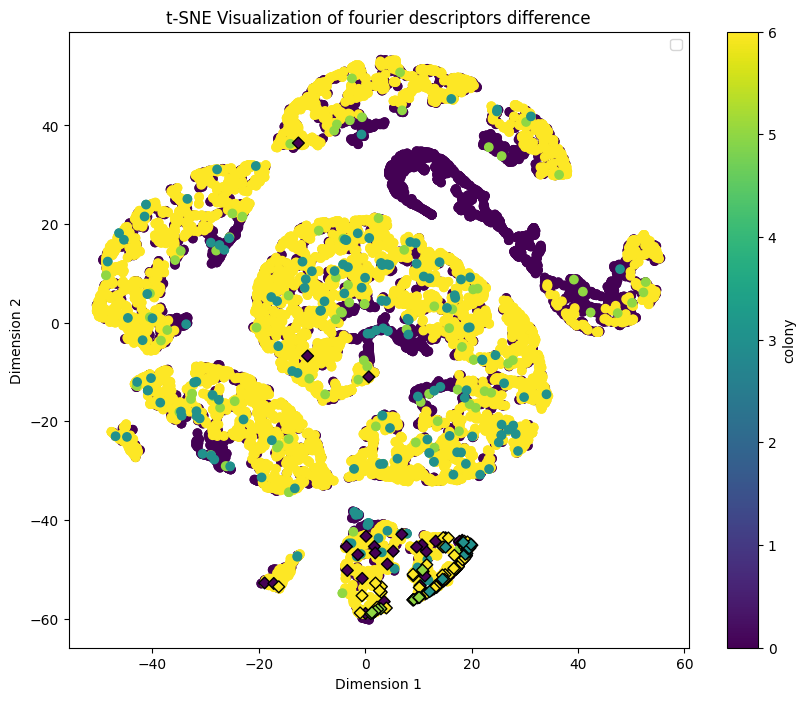

In [15]:

colormap = plt.cm.get_cmap('PiYG')
plt.figure(figsize=(10, 8))
sc = plt.scatter(Y[:, 0], Y[:, 1], c=X['colony'], marker='o')
plt.colorbar(sc, label='colony')  # Add a colorbar for the similarity values
labels = X['label'].values
unique_labels = set(X['label'])
markers = ['o', 'D']  # Example marker styles for different labels
e = [None, 'black']
c_c = [colony[labels == 0],colony[labels == 1]]
for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(Y[mask, 0], Y[mask, 1], marker=markers[i], c =c_c[i], edgecolors= e[i])
plt.title('t-SNE Visualization of fourier descriptors difference')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()  # Add a legend to distinguish marker styles
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


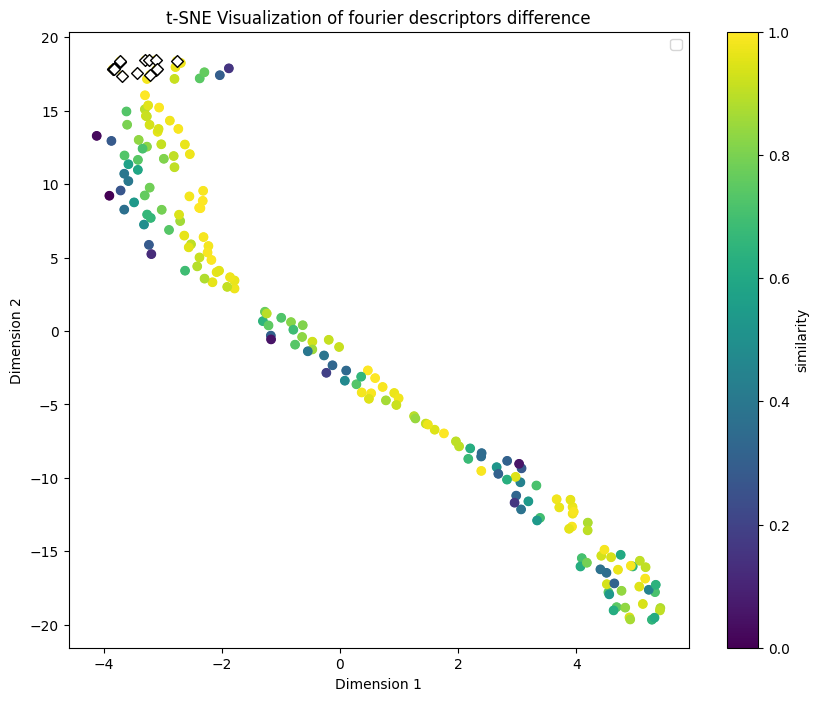

In [84]:
tsne = TSNE(n_components=2, n_jobs=4, random_state=42)
# t-sne for fourier descriptors
f_list = [f'f_diff_{i}' for i in range(1, 2*n_points + 1)]
Y = tsne.fit_transform(compare_pd_fourier[f_list].values)

# Normalize the similarity values to use them for color mapping
similarity_scaler = MinMaxScaler()
similarity_normalized = similarity_scaler.fit_transform(compare_pd_fourier['similarity'].values.reshape(-1, 1))
colormap = plt.cm.get_cmap('viridis')  # You can change 'viridis' to another colormap if desired
plt.figure(figsize=(10, 8))
sc = plt.scatter(Y[:, 0], Y[:, 1], c=similarity_normalized, cmap=colormap, marker='o', s=30)
plt.colorbar(sc, label='similarity')  # Add a colorbar for the similarity values
labels = compare_pd_fourier['label'].values
unique_labels = set(compare_pd_fourier['label'])
markers = ['o', 'D']  # Example marker styles for different labels
e = [None, 'black']
c_c = [similarity_normalized[labels == 0], "white"]
for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(Y[mask, 0], Y[mask, 1], marker=markers[i], c =c_c[i], edgecolors= e[i] ,cmap=colormap)
plt.title('t-SNE Visualization of fourier descriptors difference')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()  # Add a legend to distinguish marker styles
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


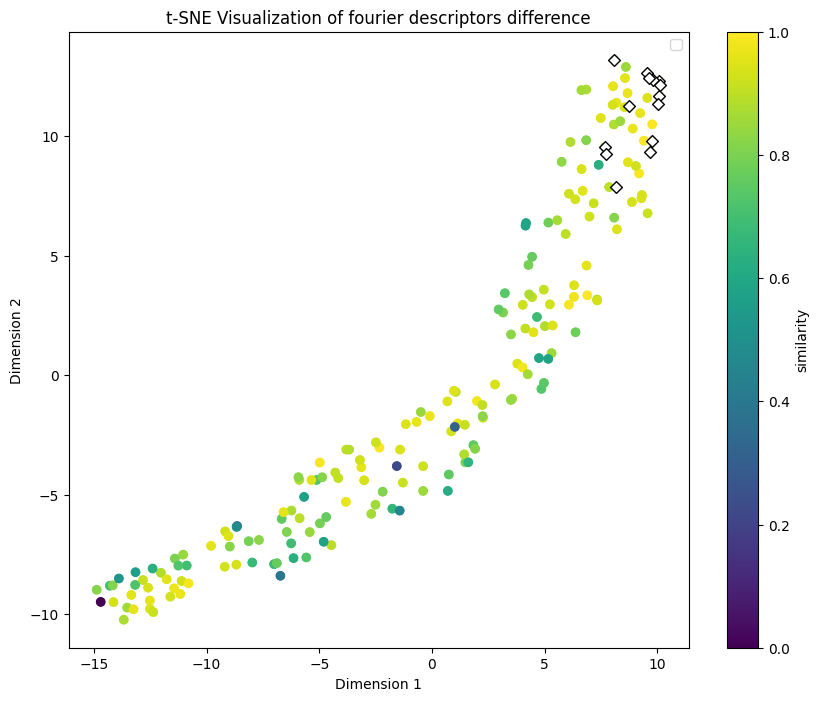

In [85]:
tsne = TSNE(n_components=2, n_jobs=4, random_state=42)
# t-sne for fourier descriptors
f_list = [f'f_diff_{i}' for i in range(1, 2*n_points + 1)]
Y = tsne.fit_transform(compare_pd_fourier_no_locality[f_list].values)
# Normalize the similarity values to use them for color mapping
similarity_scaler = MinMaxScaler()
similarity_normalized = similarity_scaler.fit_transform(compare_pd_fourier_no_locality['similarity'].values.reshape(-1, 1))
colormap = plt.cm.get_cmap('viridis')  # You can change 'viridis' to another colormap if desired
plt.figure(figsize=(10, 8))
sc = plt.scatter(Y[:, 0], Y[:, 1], c=similarity_normalized, cmap=colormap, marker='o', s=30)
plt.colorbar(sc, label='similarity')  # Add a colorbar for the similarity values
labels = compare_pd_fourier_no_locality['label'].values
unique_labels = set(compare_pd_fourier_no_locality['label'])
markers = ['o', 'D']  # Example marker styles for different labels
e = [None, 'black']
c_c = [similarity_normalized[labels == 0], "white"]
for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(Y[mask, 0], Y[mask, 1], marker=markers[i], c =c_c[i], edgecolors= e[i] ,cmap=colormap)
plt.title('t-SNE Visualization of fourier descriptors difference')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()  # Add a legend to distinguish marker styles
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


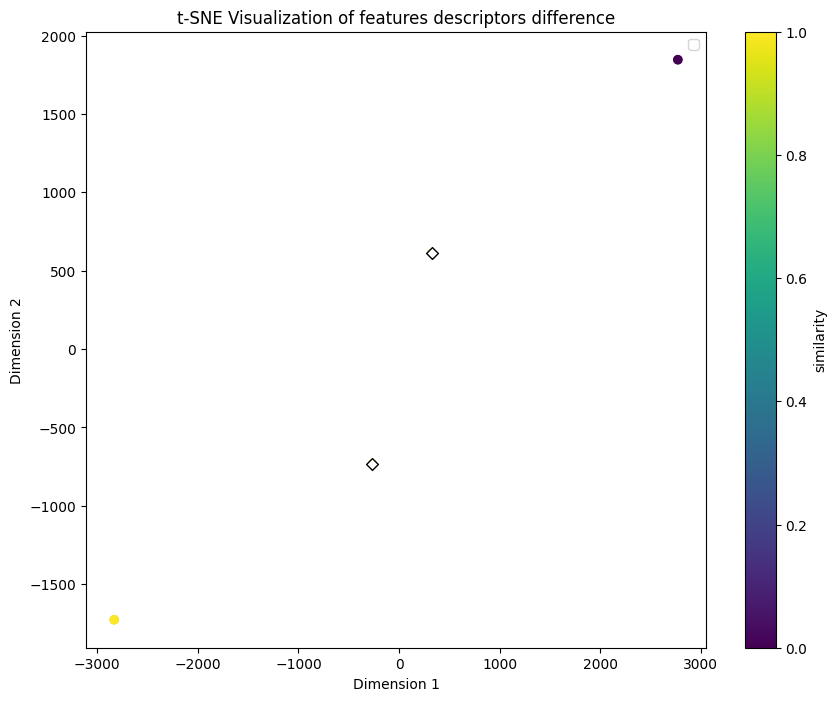

In [86]:

# t-sne for features descriptors
f_list = [f'f_diff_{i}' for i in range(1, 10 + 1)]
labels = compare_pd_features['label'].values


Y = tsne.fit_transform(compare_pd_features[f_list].values)
# Normalize the similarity values to use them for color mapping
similarity_scaler = MinMaxScaler()
similarity_normalized = similarity_scaler.fit_transform(compare_pd_features['similarity'].values.reshape(-1, 1))
colormap = plt.cm.get_cmap('viridis')  # You can change 'viridis' to another colormap if desired
plt.figure(figsize=(10, 8))
sc = plt.scatter(Y[:, 0], Y[:, 1], c=similarity_normalized, cmap=colormap, marker='o', s=30)
plt.colorbar(sc, label='similarity')  # Add a colorbar for the similarity values
unique_labels = set(compare_pd_features['label'])
markers = ['o', 'D']  # Example marker styles for different labels
e = [None, 'black']
c_c = [similarity_normalized[labels == 0], "white"]
for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(Y[mask, 0], Y[mask, 1], marker=markers[i], c =c_c[i], edgecolors= e[i] ,cmap=colormap)
plt.title('t-SNE Visualization of features descriptors difference')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()  # Add a legend to distinguish marker styles
plt.show()

ValueError: 'c' argument has 196 elements, which is inconsistent with 'x' and 'y' with size 4.

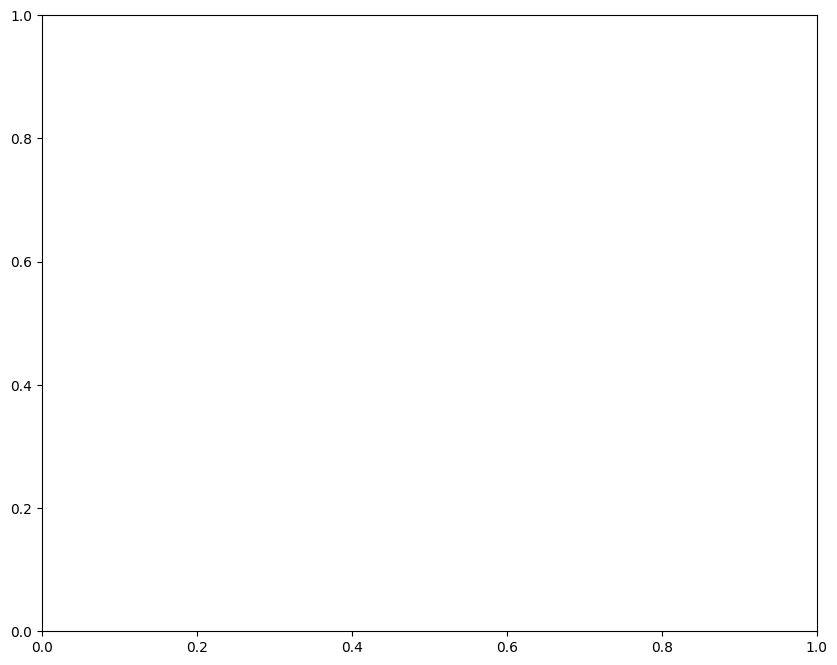

In [87]:

# t-sne for features descriptors
f_list = [f'f_diff_{i}' for i in range(1, 10 + 1)]
labels = compare_pd_features['label'].values


Y = tsne.fit_transform(compare_pd_features[f_list].values)
# Normalize the similarity values to use them for color mapping
similarity_scaler = MinMaxScaler()
similarity_normalized = similarity_scaler.fit_transform(compare_pd_fourier['similarity'].values.reshape(-1, 1))
colormap = plt.cm.get_cmap('viridis')  # You can change 'viridis' to another colormap if desired
plt.figure(figsize=(10, 8))
sc = plt.scatter(Y[:, 0], Y[:, 1], c=similarity_normalized, cmap=colormap, marker='o', s=30)
plt.colorbar(sc, label='similarity of fourier')  # Add a colorbar for the similarity values
unique_labels = set(compare_pd_features['label'])
markers = ['o', 'D']  # Example marker styles for different labels
e = [None, 'black']
c_c = [similarity_normalized[labels == 0], "white"]
for i, label in enumerate(unique_labels):
    mask = labels == label
    plt.scatter(Y[mask, 0], Y[mask, 1], marker=markers[i], c =c_c[i], edgecolors= e[i] ,cmap=colormap)
plt.title('t-SNE Visualization of features descriptors difference')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()  # Add a legend to distinguish marker styles
plt.show()